# 6.2　特征提取


In [5]:
from sklearn.feature_extraction.text import CountVectorizer
import os
from sklearn.naive_bayes import GaussianNB
from sklearn.model_selection import train_test_split
from sklearn import metrics
import matplotlib.pyplot as plt
import numpy as np
from sklearn import svm
from sklearn.feature_extraction.text import TfidfTransformer
import tensorflow as tf
import tflearn
from tflearn.layers.core import input_data, dropout, fully_connected
from tflearn.layers.conv import conv_1d, global_max_pool
from tflearn.layers.conv import conv_2d, max_pool_2d
from tflearn.layers.merge_ops import merge
from tflearn.layers.estimator import regression
from tflearn.data_utils import to_categorical, pad_sequences
from sklearn.neural_network import MLPClassifier
from tflearn.layers.normalization import local_response_normalization
import pandas as pd
# from tensorflow.contrib import learn

## 6.2.1　词袋模型

In [2]:
vectorizer=CountVectorizer(min_df=1)
vectorizer

CountVectorizer()

In [ ]:
corpus = [
    'This is the first document.',
    'This is the second second document.',
    'And the third one.',
    'Is this the first document?'
]
X = vectorizer.fit_transform(corpus)
X

<4x9 sparse matrix of type '<class 'numpy.int64'>'
	with 19 stored elements in Compressed Sparse Row format>

In [ ]:
vectorizer.get_feature_names_out() == (['and', 'document', 'first', 'is', 'one',
                                    'second', 'the', 'third', 'this'])

array([ True,  True,  True,  True,  True,  True,  True,  True,  True])

In [5]:
X.toarray()

array([[0, 1, 1, 1, 0, 0, 1, 0, 1],
       [0, 1, 0, 1, 0, 2, 1, 0, 1],
       [1, 0, 0, 0, 1, 0, 1, 1, 0],
       [0, 1, 1, 1, 0, 0, 1, 0, 1]], dtype=int64)

In [ ]:
vocabulary = vectorizer.vocabulary_
new_vectorizer = CountVectorizer(min_df=1, vocabulary=vocabulary)

In [2]:
max_features=5000
max_document_length=100

def load_one_file(filename):
    x=""
    with open(filename, encoding='utf-8', errors='ignore') as f:
        for line in f:
            line=line.strip('\n')
            line = line.strip('\r')
            x+=line
    return x

def load_files_from_dir(rootdir):
    x=[]
    list = os.listdir(rootdir)
    for i in range(0, len(list)):
        path = os.path.join(rootdir, list[i])
        if os.path.isfile(path):
            # print(path)
            v=load_one_file(path)
            x.append(v)
    return x

def load_all_files():
    ham=[]
    spam=[]
    for i in range(1,2):
        path="../Data/mail/enron%d/ham/" % i
        print("Load %s" % path)
        ham+=load_files_from_dir(path)
        path="../Data/mail/enron%d/spam/" % i
        print("Load %s" % path)
        spam+=load_files_from_dir(path)
    return ham,spam

使用词袋模型，向量化正常邮件和垃圾邮件样本，其中ham文件夹下的样本标记为0，表示正常邮件，spam文件夹下的样本标记为1，表示垃圾邮件：

In [54]:
ham, spam=load_all_files()

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/


In [67]:
pd.DataFrame(spam,columns=['垃圾邮件'])

,垃圾邮件
0,Subject: dobmeos with hgh my energy level has ...
1,Subject: your prescription is ready . . oxwq s...
2,Subject: get that new car 8434people nowthe we...
3,"Subject: await your responsedear partner ,we a..."
4,"Subject: coca cola , mbna america , nascar par..."
...,...
1495,Subject: our pro - forma invoice attacheddivid...
1496,Subject: str _ rndlen ( 2 - 4 ) } { extra _ ti...
1497,Subject: check me out !61 bbhey dermbbbbbcheck...
1498,Subject: hot jobsglobal marketing specialties ...


In [68]:
pd.DataFrame(ham,columns=['正常邮件'])

,正常邮件
0,Subject: christmas tree farm pictures
1,"Subject: vastar resources , inc .gary , produc..."
2,Subject: calpine daily gas nomination- calpine...
3,Subject: re : issuefyi - see note below - alre...
4,Subject: meter 7268 nov allocationfyi .- - - -...
...,...
3667,Subject: re : tenaska ivi ' ll call you on thu...
3668,"Subject: generic contracthi daren ,sorry for t..."
3669,Subject: re : contracts and creditthanks - - i...
3670,"Subject: re : tenaska ivok , since we don ' t ..."


In [3]:

def get_features_by_wordbag():
    ham, spam=load_all_files()
    x=ham+spam
    y=[0]*len(ham)+[1]*len(spam)
    vectorizer = CountVectorizer(
                                 decode_error='ignore', # 处理解码失败的方式，分为“strict”​“ignore”​“replace”3种方式
                                 strip_accents='ascii',
                                 max_features=max_features,
                                 stop_words='english',
                                 max_df=1.0,
                                 min_df=1 )
    print(vectorizer)
    x=vectorizer.fit_transform(x)
    x=x.toarray()
    return x,y


In [4]:
x,y = get_features_by_wordbag()

NameError: name 'load_all_files' is not defined

In [80]:
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,2,18,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5168,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5169,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
5170,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [81]:
t= pd.DataFrame(x)
t.iloc[0]


0       0
1       0
2       0
3       0
4       0
       ..
4995    0
4996    0
4997    0
4998    0
4999    0
Name: 0, Length: 5000, dtype: int64

In [82]:
t[t[0]!=0][0]

1       2
7       1
17      1
36      1
37      5
       ..
5085    1
5110    2
5114    2
5151    1
5154    1
Name: 0, Length: 626, dtype: int64

## 6.2.2　TF-IDF模型

In [ ]:
from sklearn.feature_extraction.text import TfidfTransformer 
transformer = TfidfTransformer(smooth_idf=False)
transformer

TfidfTransformer(smooth_idf=False)

定义了一个名为counts的列表，其中包含了多个子列表。每个子列表代表一个文档中词语出现的次数（这里简化为二维数组，每个子列表代表一个文档，列表中的数字代表词语出现的次数）

In [69]:
counts = [[3, 0, 1],
        [2, 0, 0],
        [3, 0, 0], 
        [4, 0, 0], 
        [3, 2, 0], 
        [3, 0, 2]]  

调用Tfidf方法从transformer模块中，将counts矩阵转换为TF-IDF矩阵。fit_transform方法计算了每个词语的TF-IDF值，并将结果存储在变量tfidf中。

In [70]:
tfidf = transformer.fit_transform(counts)
tfidf        

<6x3 sparse matrix of type '<class 'numpy.float64'>'
	with 9 stored elements in Compressed Sparse Row format>

打印tfidf变量，显示转换后的TF-IDF矩阵。输出显示这是一个稀疏矩阵，意味着很多值都是0，这在处理大型数据集时可以节省内存和计算资源。

调用tfidf.toarray()方法将稀疏矩阵转换为常规的NumPy数组，以便更直观地查看转换后的结果。

In [20]:
tfidf.toarray()

array([[0.81940995, 0.        , 0.57320793],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [1.        , 0.        , 0.        ],
       [0.47330339, 0.88089948, 0.        ],
       [0.58149261, 0.        , 0.81355169]])

打印转换后的数组，显示了每个词语在每个文档中的TF-IDF值。TF-IDF值越高，表示词语在文档中越重要，但在整个文档集合中不那么常见

In [83]:
def get_features_by_wordbag_tfidf():
    ham, spam=load_all_files()
    x=ham+spam
    y=[0]*len(ham)+[1]*len(spam)
    vectorizer = CountVectorizer(binary=True,
                                 decode_error='ignore',
                                 strip_accents='ascii',
                                 max_features=max_features,
                                 stop_words='english',
                                 max_df=1.0,
                                 min_df=1 )
    print(vectorizer)
    x=vectorizer.fit_transform(x)
    x=x.toarray()
    transformer = TfidfTransformer(smooth_idf=False)
    print(transformer)
    tfidf = transformer.fit_transform(x)
    x = tfidf.toarray()
    return  x,y
    
x,y = get_features_by_wordbag_tfidf()

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(binary=True, decode_error='ignore', max_features=5000,
                stop_words='english', strip_accents='ascii')
TfidfTransformer(smooth_idf=False)


In [84]:
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,4990,4991,4992,4993,4994,4995,4996,4997,4998,4999
0,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
1,0.067431,0.061318,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
3,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
4,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5168,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5169,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0
5170,0.000000,0.000000,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,...,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0


## 6.2.3　词汇表模型

In [114]:
# x_text =[
#         'i love you',
#         'me too']
# vocab_processor = tf.contrib.learn.preprocessing.VocabularyProcessor(
#                                 max_document_length,
#                                 min_frequency=0,
#                                 vocabulary=None,
#                                 tokenizer_fn=None)
# vocab_processor.fit(x_text)
# next(vocab_processor.transform(x_text)).tolist()
# x = np.array(list(vocab_processor.fit_transform(x_text)))

In [ ]:
x_text = [
    'i love you',
    'me too'
]

# 创建一个Tokenizer对象
tokenizer = tf.keras.preprocessing.text.Tokenizer(
    num_words=None,  # 如果为 None，则词汇表大小由文本数据动态确定
    lower=True  # 是否将文本转换为小写
)

# 使用文本数据拟合Tokenizer
tokenizer.fit_on_texts(x_text)

# 使用tokenizer转换文本
encoded_text = tokenizer.texts_to_sequences(x_text)
print(encoded_text)

[[1, 2, 3], [4, 5]]


In [104]:
tokenizer.texts_to_sequences(["i me too"])

[[1, 4, 5]]

In [6]:
# def get_features_by_tf():
#     global  max_document_length
#     x=[]
#     y=[]
#     ham, spam=load_all_files()
#     x=ham+spam
#     y=[0]*len(ham)+[1]*len(spam)
#     vp=tflearn.data_utils.VocabularyProcessor(max_document_length=max_document_length,
#                                               min_frequency=0,
#                                               vocabulary=None,
#                                               tokenizer_fn=None)
#     x=vp.fit_transform(x, unused_y=None)
#     x=np.array(list(x))
#     return x,y

from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences

def get_features_by_tf():
    global max_document_length
    x = []
    y = []
    ham, spam = load_all_files()
    x = ham + spam
    y = [0] * len(ham) + [1] * len(spam)

    # Initialize the Tokenizer
    tokenizer = Tokenizer(num_words=max_features, oov_token='<OOV>')
    tokenizer.fit_on_texts(x)

    # Convert texts to sequences
    x = tokenizer.texts_to_sequences(x)

    # Pad sequences to ensure uniform input size
    x = pad_sequences(x, maxlen=max_document_length, padding='post')

    return x, y

x, y = get_features_by_tf()

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/


In [116]:
pd.DataFrame(x)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,15,3083,4959,4418,2058,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,120,1,182,411,104,47,120,1,182,411,...,122,1,182,411,647,47,122,1,182,411
2,15,640,222,36,185,640,222,36,185,41,...,0,0,0,0,0,0,0,0,0,0
3,471,165,1,202,111,150,53,88,1087,99,...,6,63,111,127,13,42,1,1362,65,111
4,1,73,34,1328,2224,11,4,13,86,53,...,31,1190,282,2,2059,129,492,1,941,60
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
5167,15,49,986,1,712,1,770,390,1835,2068,...,0,0,0,0,0,0,0,0,0,0
5168,15,1,1,45,65,1823,116,65,1531,1,...,0,0,0,0,0,0,0,0,0,0
5169,15,415,43,90,2295,1,1,90,1,5,...,0,0,0,0,0,0,0,0,0,0
5170,15,1321,1,595,1,3071,803,827,911,1,...,0,0,0,0,0,0,0,0,0,0


# 6.3　模型训练与验证

## 6.3.1　朴素贝叶斯算法

In [ ]:
def do_nb_wordbag(x_train, x_test, y_train, y_test):
    print("NB and wordbag")
    gnb = GaussianNB()
    gnb.fit(x_train,y_train)
    y_pred=gnb.predict(x_test)
    print(metrics.accuracy_score(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))

In [120]:
x,y = get_features_by_wordbag()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)
gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred=gnb.predict(x_test)

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=5000, stop_words='english',
                strip_accents='ascii')


In [121]:
metrics.accuracy_score(y_test, y_pred)

0.9555340744320928

In [122]:
metrics.confusion_matrix(y_test, y_pred)

array([[1405,   58],
       [  34,  572]], dtype=int64)

max_features=1000
Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=1000, stop_words='english',
                strip_accents='ascii')
max_features=3000
Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=3000, stop_words='english',
                strip_accents='ascii')
max_features=5000
Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=5000, stop_words='english',
                strip_accents='ascii')
max_features=7000
Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=7000, stop_words='english',
                strip_accents='ascii')
max_features=9000
Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=9000, stop_words='english',
                strip_accents='ascii')
max_featur

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


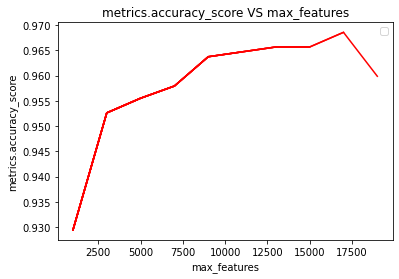

In [123]:
def show_diffrent_max_features():
    global max_features
    a=[]
    b=[]
    for i in range(1000,20000,2000):
        max_features=i
        print("max_features=%d" % i)
        x, y = get_features_by_wordbag()
        x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)
        gnb = GaussianNB()
        gnb.fit(x_train, y_train)
        y_pred = gnb.predict(x_test)
        score=metrics.accuracy_score(y_test, y_pred)
        a.append(max_features)
        b.append(score)
        plt.plot(a, b, 'r')
    plt.xlabel("max_features")
    plt.ylabel("metrics.accuracy_score")
    plt.title("metrics.accuracy_score VS max_features")
    plt.legend()
    plt.show()
show_diffrent_max_features()

In [124]:
x,y=get_features_by_wordbag_tfidf()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)
gnb = GaussianNB()
gnb.fit(x_train,y_train)
y_pred=gnb.predict(x_test)

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(binary=True, decode_error='ignore', max_features=19000,
                stop_words='english', strip_accents='ascii')
TfidfTransformer(smooth_idf=False)


In [125]:
metrics.accuracy_score(y_test, y_pred)

0.972933784436926

In [126]:
metrics.confusion_matrix(y_test, y_pred)

array([[1439,   24],
       [  32,  574]], dtype=int64)

## 6.3.2　支持向量机算法

In [130]:
def do_svm_wordbag(x_train, x_test, y_train, y_test):
    print("SVM and wordbag")
    clf = svm.SVC()
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(metrics.accuracy_score(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))

In [ ]:
x,y = get_features_by_wordbag()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

do_svm_wordbag(x_train, x_test, y_train, y_test)

SVM and wordbag
Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=19000, stop_words='english',
                strip_accents='ascii')
0.9739004349927501
[[1429   34]
 [  20  586]]


In [128]:
print("SVM and wordbag")
x,y = get_features_by_wordbag_tfidf()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)

do_svm_wordbag(x_train, x_test, y_train, y_test)

SVM and wordbag
Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(binary=True, decode_error='ignore', max_features=19000,
                stop_words='english', strip_accents='ascii')
TfidfTransformer(smooth_idf=False)
0.9908168197196714
[[1451   12]
 [   7  599]]


## 6.3.3　深度学习算法之MLP

In [131]:
def do_dnn_wordbag(x_train, x_test, y_train, y_test):
    print("DNN and wordbag")

    # Building deep neural network
    clf = MLPClassifier(solver='lbfgs',
                        alpha=1e-5,
                        hidden_layer_sizes = (5, 2),
                        random_state = 1)
    print( clf)
    clf.fit(x_train, y_train)
    y_pred = clf.predict(x_test)
    print(metrics.accuracy_score(y_test, y_pred))
    print(metrics.confusion_matrix(y_test, y_pred))

In [132]:
x,y = get_features_by_wordbag()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)
do_dnn_wordbag(x_train, x_test, y_train, y_test)

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(decode_error='ignore', max_features=19000, stop_words='english',
                strip_accents='ascii')
DNN and wordbag
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
0.9811503141614306
[[1446   17]
 [  22  584]]


In [133]:
x,y = get_features_by_wordbag_tfidf()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)
do_dnn_wordbag(x_train, x_test, y_train, y_test)

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
CountVectorizer(binary=True, decode_error='ignore', max_features=19000,
                stop_words='english', strip_accents='ascii')
TfidfTransformer(smooth_idf=False)
DNN and wordbag
MLPClassifier(alpha=1e-05, hidden_layer_sizes=(5, 2), random_state=1,
              solver='lbfgs')
0.7071048815853069
[[1463    0]
 [ 606    0]]


## 6.3.4　深度学习算法之CNN

In [134]:
def do_cnn_wordbag(trainX, testX, trainY, testY):
    global max_document_length
    print("CNN and tf")

    trainX = pad_sequences(trainX, maxlen=max_document_length, value=0.)
    testX = pad_sequences(testX, maxlen=max_document_length, value=0.)
    # Converting labels to binary vectors
    trainY = to_categorical(trainY, nb_classes=2)
    testY = to_categorical(testY, nb_classes=2)

    # Building convolutional network
    network = input_data(shape=[None,max_document_length], name='input')
    network = tflearn.embedding(network, input_dim=1000000, output_dim=128)
    branch1 = conv_1d(network, 128, 3, padding='valid', activation='relu', regularizer="L2")
    branch2 = conv_1d(network, 128, 4, padding='valid', activation='relu', regularizer="L2")
    branch3 = conv_1d(network, 128, 5, padding='valid', activation='relu', regularizer="L2")
    network = merge([branch1, branch2, branch3], mode='concat', axis=1)
    network = tf.expand_dims(network, 2)
    network = global_max_pool(network)
    network = dropout(network, 0.8)
    network = fully_connected(network, 2, activation='softmax')
    network = regression(network, optimizer='adam', learning_rate=0.001,
                         loss='categorical_crossentropy', name='target')
    # Training
    model = tflearn.DNN(network, tensorboard_verbose=0)
    model.fit(trainX, trainY,
              n_epoch=5, shuffle=True, validation_set=(testX, testY),
              show_metric=True, batch_size=100,run_id="spam")

In [135]:
x,y = get_features_by_wordbag()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size = 0.4, random_state = 0)
do_cnn_wordbag(x_train, x_test, y_train, y_test)

Training Step: 159  | total loss: 0.59738 | time: 35.088s
| Adam | epoch: 005 | loss: 0.59738 - acc: 0.7185 -- iter: 3100/3103
Training Step: 160  | total loss: 0.59925 | time: 37.318s
| Adam | epoch: 005 | loss: 0.59925 - acc: 0.7166 | val_loss: 0.60480 - val_acc: 0.7071 -- iter: 3103/3103
--


In [141]:
pd.DataFrame(x_train)

,0,1,2,3,4,5,6,7,8,9,...,18990,18991,18992,18993,18994,18995,18996,18997,18998,18999
0,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3099,0,2,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3101,0,1,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [140]:
ps = pad_sequences(x_train, maxlen=max_document_length, value=0.)
pd.DataFrame(ps)

,0,1,2,3,4,5,6,7,8,9,...,90,91,92,93,94,95,96,97,98,99
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
3098,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3099,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3100,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3101,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


## 6.3.5　深度学习算法之RNN

In [ ]:
def do_rnn_wordbag(trainX, testX, trainY, testY):
    global max_document_length
    print("RNN and wordbag")

    trainX = pad_sequences(trainX, maxlen=max_document_length, value=0)
    testX = pad_sequences(testX, maxlen=max_document_length, value=0)
    # Converting labels to binary vectors
    trainY = to_categorical(trainY, nb_classes=2)
    testY = to_categorical(testY, nb_classes=2)

    # Network building
    net = tflearn.input_data([None, max_document_length])
    net = tflearn.embedding(net, input_dim=5000, output_dim=128)
    net = tflearn.lstm(net, 128, dropout=0.8)
    net = tflearn.fully_connected(net, 2, activation='softmax')
    net = tflearn.regression(net, optimizer='adam', learning_rate=0.001,
                             loss='categorical_crossentropy')

    # Training
    model = tflearn.DNN(net, tensorboard_verbose=0)
    model.fit(trainX, trainY, validation_set=(testX, testY), show_metric=True,
              batch_size=10,run_id="spm-run",n_epoch=5)
# 获取特征
x, y = get_features_by_wordbag()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

do_rnn_wordbag(x_train, x_test, y_train, y_test)


In [ ]:
import tensorflow as tf
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.model_selection import train_test_split

def get_features_by_wordbag():
    ham, spam = load_all_files()  # 确保这个函数被正确定义并返回数据
    x = ham + spam
    y = [0] * len(ham) + [1] * len(spam)
    max_features = 5000  # 定义 max_features
    vectorizer = CountVectorizer(
        decode_error='ignore',
        strip_accents='ascii',
        max_features=max_features,
        stop_words='english',
        max_df=1.0,
        min_df=1
    )
    x = vectorizer.fit_transform(x)
    x = x.toarray()
    return x, y

def do_rnn_wordbag(trainX, testX, trainY, testY):
    # 由于 trainX 和 testX 已经是数值化的特征，不需要转换为文本
    # 直接使用数值特征
    max_document_length = max(trainX.shape[1], testX.shape[1])  # 获取最大特征长度

    trainX_padded = pad_sequences(trainX, maxlen=max_document_length, padding='post', truncating='post')
    testX_padded = pad_sequences(testX, maxlen=max_document_length, padding='post', truncating='post')

    trainY_categorical = tf.keras.utils.to_categorical(trainY, num_classes=2)
    testY_categorical = tf.keras.utils.to_categorical(testY, num_classes=2)

    model = Sequential([
        Embedding(input_dim=5000, output_dim=128, input_length=max_document_length),
        Dropout(0.2),
        LSTM(128, dropout=0.2),
        Dense(2, activation='softmax')
    ])

    model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

    model.fit(trainX_padded, trainY_categorical, validation_data=(testX_padded, testY_categorical),
              batch_size=10, epochs=5, verbose=1)

    loss, accuracy = model.evaluate(testX_padded, testY_categorical)
    print(f"Test accuracy: {accuracy:.2f}")

# 假设 load_all_files 和 train_test_split 函数已经定义
x, y = get_features_by_wordbag()
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.4, random_state=0)

do_rnn_wordbag(x_train, x_test, y_train, y_test)

Load ../Data/mail/enron1/ham/
Load ../Data/mail/enron1/spam/
Instructions for updating:
Call initializer instance with the dtype argument instead of passing it to the constructor


NotImplementedError: Cannot convert a symbolic Tensor (lstm_6/strided_slice:0) to a numpy array. This error may indicate that you're trying to pass a Tensor to a NumPy call, which is not supported